In [1]:
from imports import *
import params

In [23]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=0, high=255, shape=self.observation_space.shape[:2], dtype=np.uint8)

    def observation(self, observation):
        transform = transforms.Grayscale()
        return transform(torch.tensor(np.transpose(observation, (2, 0, 1)).copy(), dtype=torch.float))


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        self.shape = (shape, shape)
        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transformations = transforms.Compose([transforms.Resize(self.shape), transforms.Normalize(0, 255)])
        #output = (input - mean)/std , so (input-0)/255
        output =  transformations(observation).squeeze(0).numpy() #Need PIL here, trying numpy
        return output

In [24]:
env = gym.make('BreakoutNoFrameskip-v4')

# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
#env = FrameStack(env, num_stack=4)

env.seed(params.seed)
env.action_space.seed(params.seed)
torch.manual_seed(params.seed)
torch.random.manual_seed(params.seed)
random.seed(params.seed)
np.random.seed(params.seed)

from stable_baselines3.common.env_checker import check_env
check_env(env)



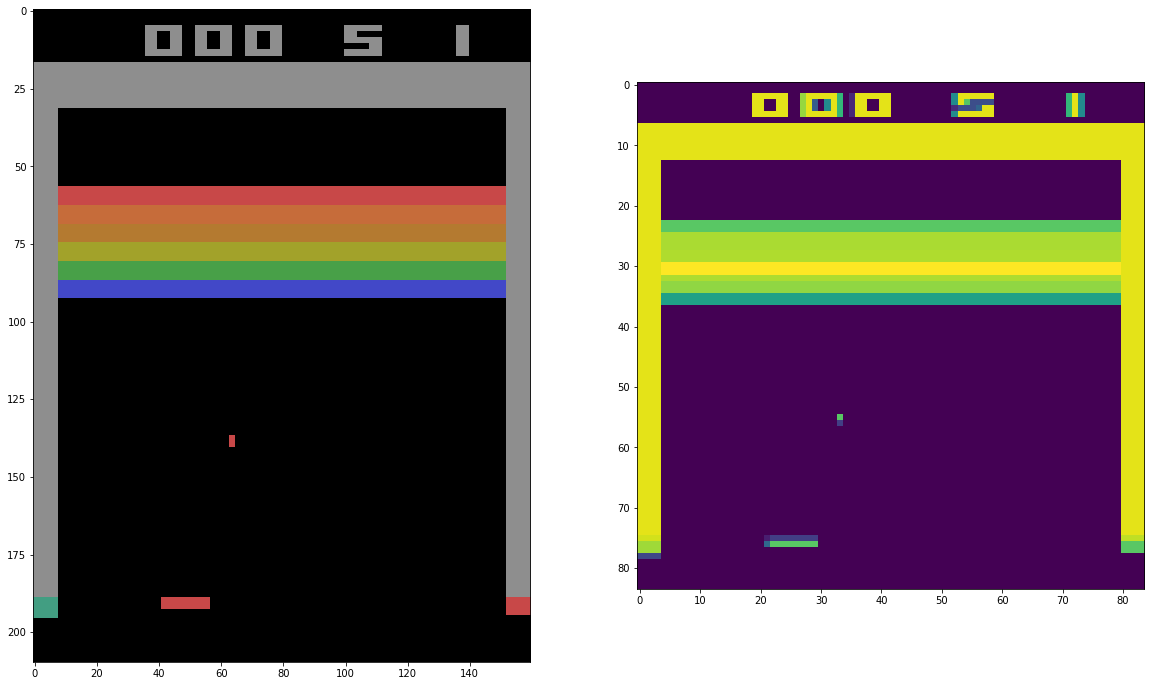

In [25]:
env.reset()
env.step(1) #Fire starts the ball rolling; need to do this every life
for i in range(3):
    next_state, reward, done, info = env.step(3)
fr = env.render(mode="rgb_array")
f, ax = plt.subplots(1,2, figsize=(20, 12))
ax[0].imshow(fr)
#ax[1].imshow(np.sum(next_state.__array__(),axis=0))
ax[1].imshow(next_state.__array__())